Initialize

In [1]:
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.model_selection import train_test_split
import os
os.environ["KERAS_BACKEND"] = "torch"   # Must be called before importing keras
import keras
import torch
from scipy import stats

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Testing GPU access
## Using pytorch because jax won't work with cuda on Windows 11, and the tensorflow installation didn't recognize the gpu
## However, pytorch is MUCH slower when all use the GPU.
print("Is CUDA available:", torch.cuda.is_available())
print("Current device:", torch.cuda.get_device_name(0))

Is CUDA available: True
Current device: NVIDIA GeForce GTX 1660 Ti


Import data and concatenate

In [3]:
outs = pl.read_excel("Data/Outcomes/outcomes.xlsx")
preds = pl.read_csv("Data/Predictors/Sleep(1).csv")
for i in range(9):
    temp = pl.read_csv(f"Data/Predictors/Sleep({i + 2}).csv")
    preds = pl.concat([preds, temp], how = "vertical")
preds = preds.rename({"Sleep Score 4 Weeks": "Date", "Score": "Sleep Score"})

# Retain only useful columns
preds = preds.select(pl.nth(0,1,2,3,5, 6, 7))

# Convert date column to date format
preds = preds.with_columns(
    (pl.col("Date") + " 2024")
    .str.strptime(pl.Date, format="%b %e %Y")
    .alias("Date"))

Merge factors and outcome on date

In [4]:
# Note: the predictors are mnissing data for 9/24/24 due to crossing the dateline.
df = preds.join(outs, how = "inner", on = "Date")

Convert temperature changes to numeric

In [5]:
df = df.with_columns(
    pl.col("Skin Temp Change").str.strip_chars_end("°").cast(pl.Float64))

EDA

Mean active calories: 228.5300751879699
Standard deviation of active calories: 123.39002682365873


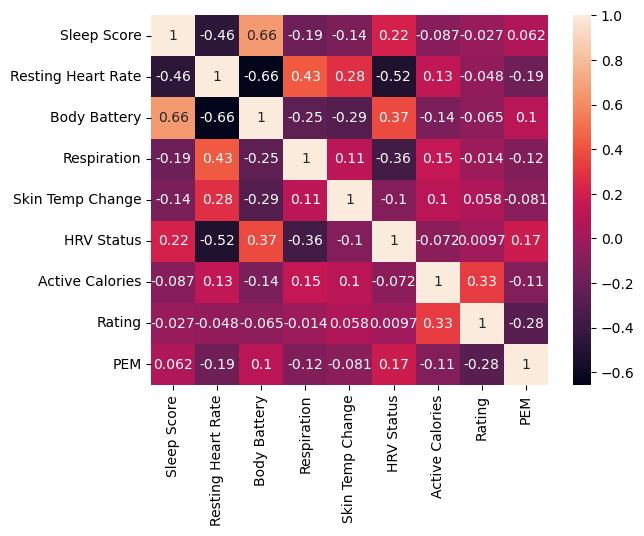

In [6]:
dfp = df.to_pandas()
matrix = dfp.iloc[:, 1:10].corr()
sns.heatmap(matrix, annot=True)

# Check average to get sense of meaningfully close predictions
print(f"Mean active calories: {np.mean(dfp.iloc[:, 7])}")
print(f"Standard deviation of active calories: {np.std(dfp.iloc[:, 7])}")

## Despite some collinearity, no variables appear duplicative.
## The low correlations between the outcomes and any other variable, including other outcomes,
    ## portend ill for the analysis' success.

Standardize and split data

In [7]:
scaler = StandardScaler()
dfp.iloc[:, 1:7] = scaler.fit_transform(dfp.iloc[:, 1:7])

# Initial split between train, validation, and test sets
## Prioritizing training due to small dataset
dfp_train, dfp_test = train_test_split(dfp.iloc[:, 1:], test_size=0.3, random_state=123)
dfp_test, dfp_val = train_test_split(dfp_test, test_size=0.5, random_state=123)
X_train = dfp_train.iloc[:, 0:6]
y_train = dfp_train.iloc[:, 6]
X_val = dfp_val.iloc[:, 0:6]
y_val = dfp_val.iloc[:, 6]
X_test = dfp_test.iloc[:, 0:6]
y_test = dfp_test.iloc[:, 6]

Create model in Keras with PyTorch backend

In [8]:
##Each hyperparameter, including the number of layers, whether to use L2 regularization on each layer, 
## the number of nodes, the dropout rate, and the L2 penalty was determined through  a manual grid search.
## The lowest (i.e. best) MAE on the validation set was 85.5 active calories; this model's MAE on the test set was 105.9.

keras.utils.set_random_seed(123)
input_shape = (6,)
nodes = 15
drop_rate = 0.5
pen = 0.01

model = keras.Sequential(
    [ keras.layers.Input(shape = input_shape),
        keras.layers.Dense(10, activation="relu", 
                           kernel_initializer = keras.initializers.HeNormal(), 
                           name = "layer1"),
        keras.layers.Dropout(drop_rate, name = "dropout1"),
        keras.layers.Dense(15, activation="relu", 
                           kernel_initializer = keras.initializers.HeNormal(), 
                           name = "layer2"),
        keras.layers.Dropout(drop_rate, name = "dropout2"),
        keras.layers.Dense(20, activation="relu",  
                           kernel_initializer = keras.initializers.HeNormal(), 
                           name = "layer3"),
        keras.layers.Dense(1, activation = "linear", 
                           kernel_regularizer=keras.regularizers.L2(l2=pen), 
                           kernel_initializer = keras.initializers.HeNormal(), 
                           name = "output")])
model.summary()

model.compile(
    loss=keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    metrics=[keras.metrics.MeanAbsoluteError(name="mae")])

callbacks = [keras.callbacks.EarlyStopping(monitor="val_mae", patience=100)]

results = model.fit(
    X_train, 
    y_train, 
    validation_data = (X_val, y_val), 
    epochs = 1000, 
    verbose = 1,
    callbacks=callbacks,
    batch_size = 32)

test_metrics = model.evaluate(X_test, y_test, verbose=2)

model.save("final_model.keras")  # save final model
model_final = keras.saving.load_model("final_model.keras")  # reload
predictions = model_final.predict(X_test) # make predictions

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ layer1 (Dense)                  │ (None, 10)             │            70 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1 (Dropout)              │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer2 (Dense)                  │ (None, 15)             │           165 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout2 (Dropout)              │ (None, 15)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer3 (Dense)                  │ (None, 20)             │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 576 (2.25 KB)

 Trainable params: 576 (2.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 65143.7422 - mae: 223.6164 - val_loss: 62681.2734 - val_mae: 225.2901
Epoch 2/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 67105.4609 - mae: 223.7546 - val_loss: 62581.0859 - val_mae: 225.0625
Epoch 3/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 60759.5078 - mae: 217.5097 - val_loss: 62484.0000 - val_mae: 224.8432
Epoch 4/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 60966.1680 - mae: 218.9056 - val_loss: 62389.4766 - val_mae: 224.6317
Epoch 5/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 61145.6914 - mae: 216.3400 - val_loss: 62300.8047 - val_mae: 224.4314
Epoch 6/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 58557.8555 - mae: 214.5452 - val_loss: 62214.1797 - val_mae: 224.2372
Epoch 7/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 67485.5703 - mae: 225.1755 - val_loss: 62125.6484 - val_mae: 224.0381
Epoch 8/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 66702.9141 - mae: 222.2320 - val_loss:

Plot training and validation loss and metric

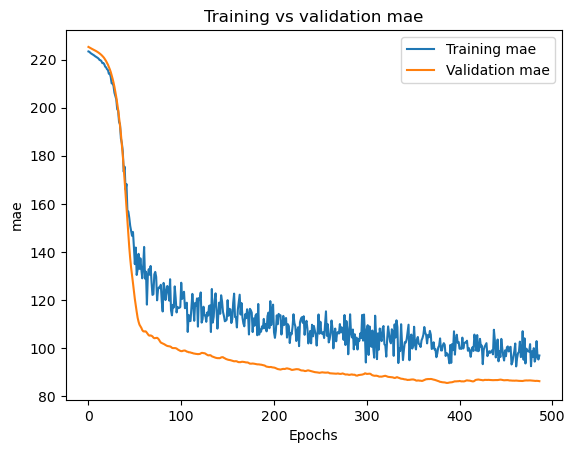

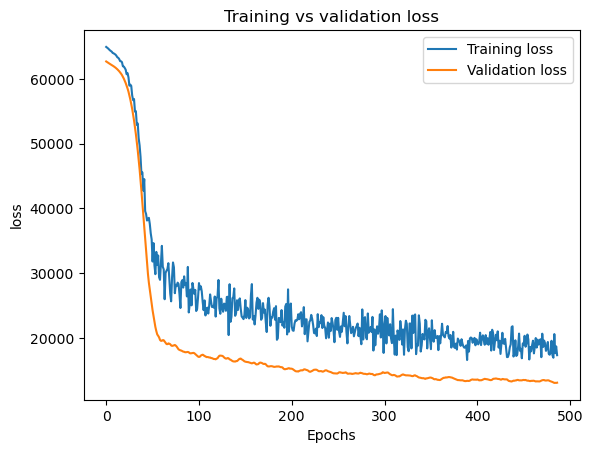

In [9]:
## Oddly, the validation metric and loss are consistently better than the training results: definitely not overfitting!
def plot_metrics(history, metric):
    plt.plot(history.history[metric], label=f'Training {metric}')
    plt.plot(history.history[f'val_{metric}'], label=f'Validation {metric}')
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.title(f'Training vs validation {metric}')
    plt.legend()
    plt.show()

# Plot accuracy
plot_metrics(results, 'mae')

# Plot loss
plot_metrics(results, 'loss')

Checking correlation of predictions to actual results, using test set 

Correlation between observations and predictions: 0.20009084274049022
Standard deviation of MAE: 106.25375550499115


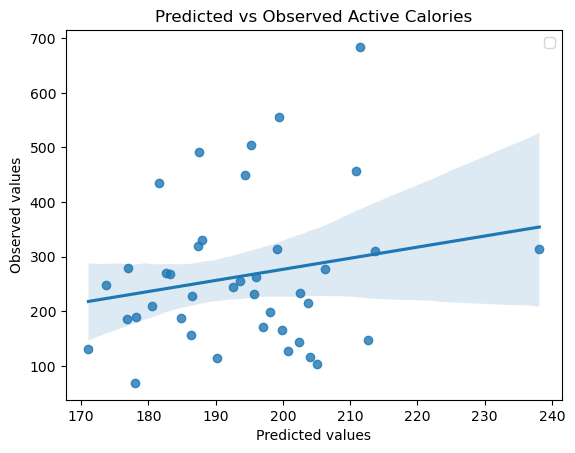

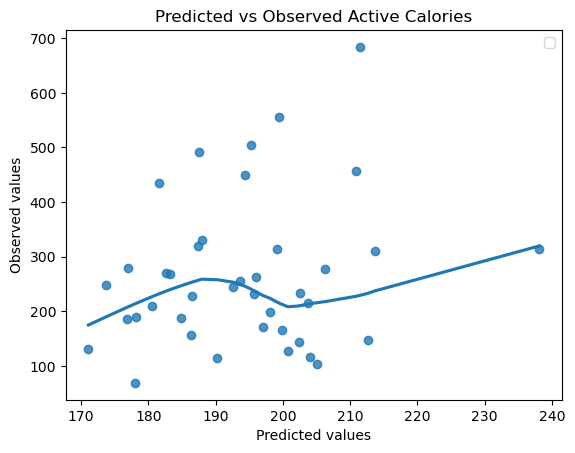

In [10]:
# Plotting lowess and linear regression lines, with 95% confidence interval for latter
## Shows tolerable linearity and homoskedasticity, but weak relationship.
## A Box-Cox transformation improved but did not eradicate the heteroskedasticity.
## Ultimately, the plots and the large stnard deviation of the errors suggest that fairly low 
## and especially higher predicted calories could result in any amount of calories.
## In short, the model is a bad predictor. Perhaps extensive post-processing or more data could ameliorate
## this weakness, but probably not enough for production.
## Nonetheless, there is a weak but discernible positive correlation (0.2).

print(f'Correlation between observations and predictions: {np.corrcoef(y_test, predictions.flatten())[1][0]}')

# Calculating the standard deviation of the errors: 106, which basically equals the MAE
print(f'Standard deviation of MAE: {np.std(np.absolute(np.subtract(y_test, predictions.flatten())))}')

sns.regplot(y = y_test, x = predictions)
plt.title('Predicted vs Observed Active Calories')
plt.xlabel('Predicted values')
plt.ylabel('Observed values')
plt.legend()
plt.show()

sns.regplot(y = y_test, x = predictions, lowess = True)
plt.title('Predicted vs Observed Active Calories')
plt.xlabel('Predicted values')
plt.ylabel('Observed values')
plt.legend()
plt.show()
